### 2kb binned feature matrix analysis 
(top 60,000 features already selected.)

In [1]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = "retina"
os.chdir("..")

In [2]:
adata = ad.read("data/epi/top60k_binned_2kb_count_matrix.h5ad")
adata

AnnData object with n_obs × n_vars = 19062 × 20002
    obs: 'NGI_ID', 'ProcessNumber', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', 'MK_ID', '10X_BATCH', 'NGS_BATCH', 'ArchR_doublet'
    var: 'transcript_annotation', 'n_cells'

In [3]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [4]:
adata.obs["log_nb_features"] = [np.log10(x) for x in adata.obs["nb_features"]]

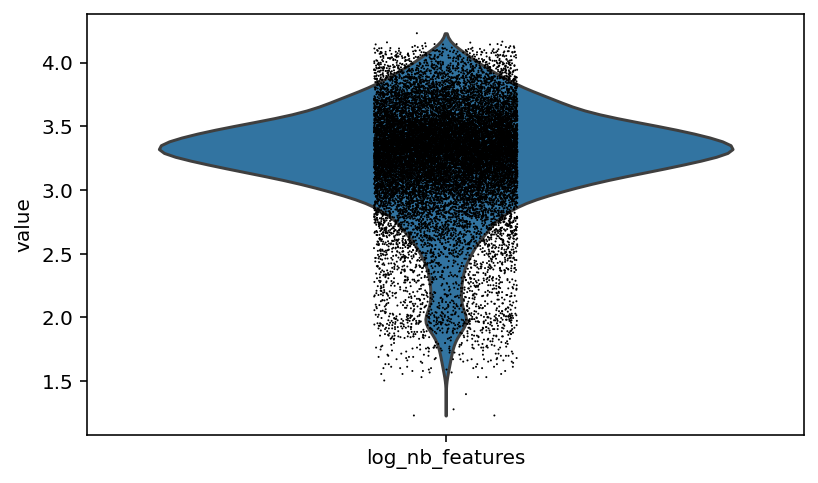

In [5]:
epi.pl.violin(adata, ["log_nb_features"])

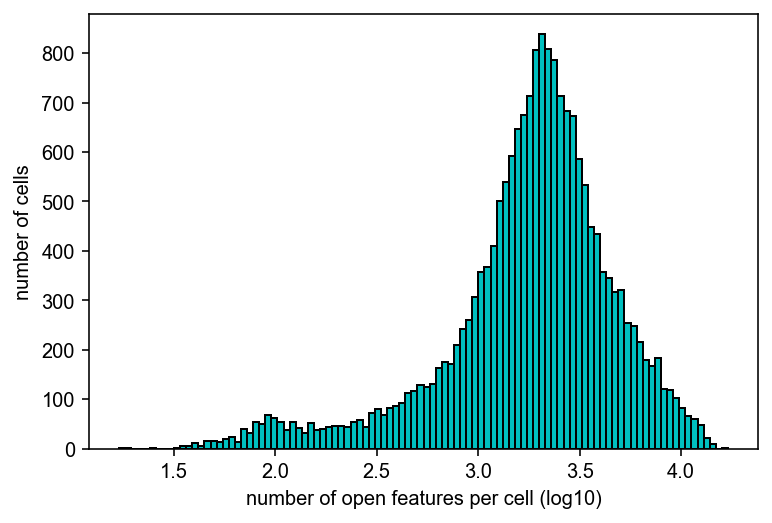

In [6]:
epi.pp.coverage_cells(adata,binary=True,log=10,bins=100)

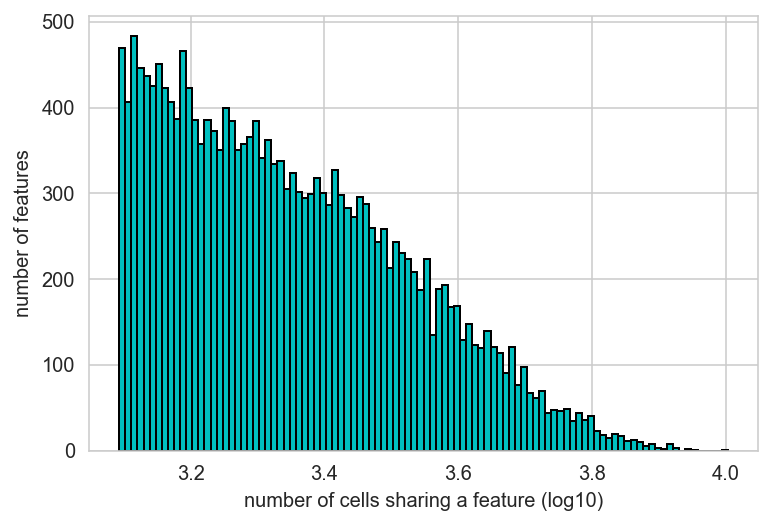

In [7]:
epi.pp.coverage_features(adata,binary=True,log=10,bins=100)  # looks funky because of the hard cut-off done earlier

In [8]:
min_features = np.quantile(adata.obs["nb_features"], 0.1) # filter out lowest 10% of cells
epi.pp.filter_cells(adata, min_features=min_features) 
adata.raw = adata

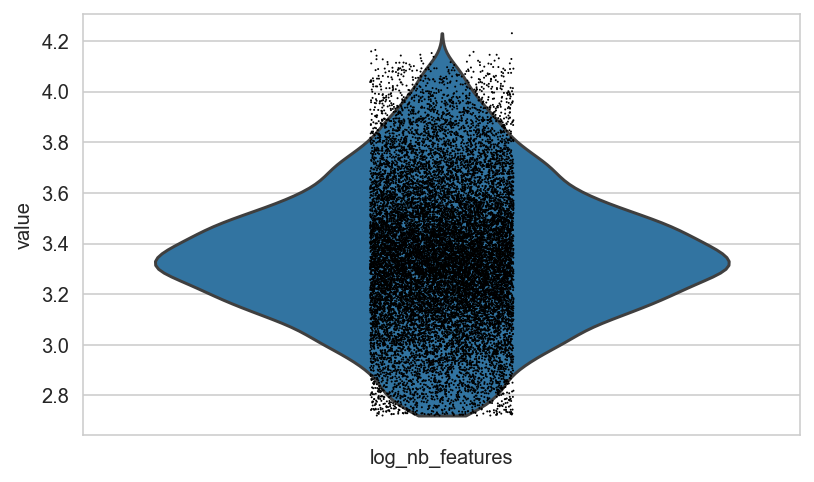

In [9]:
epi.pl.violin(adata, ['log_nb_features'])

<AxesSubplot:xlabel='Tissue', ylabel='log_nb_features'>

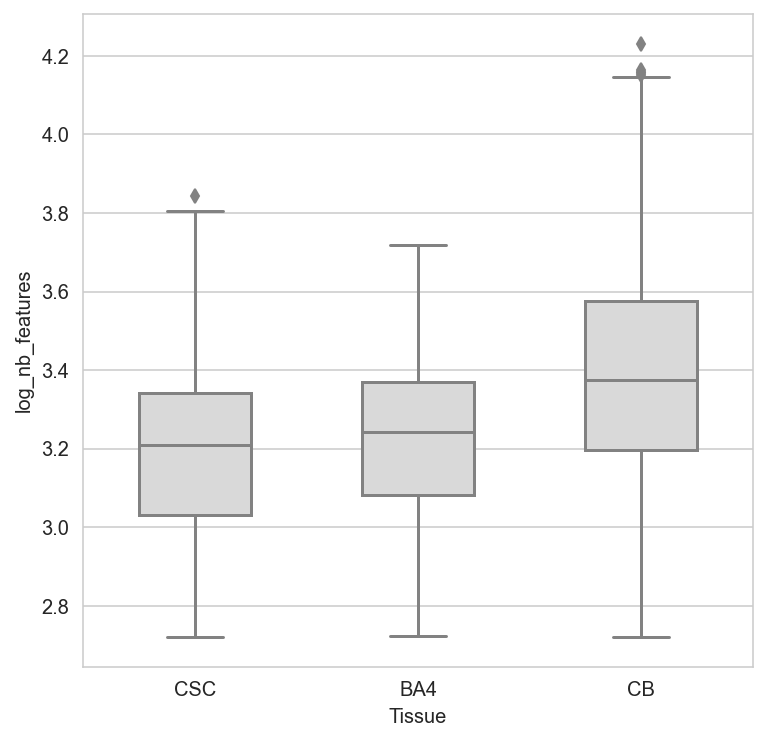

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1,figsize=(6,6))
import seaborn as sns
colors = ['0.85']
sns.boxplot(x='Tissue',y='log_nb_features',
            data=pd.DataFrame({'log_nb_features':pd.concat([CSC,BA4,CB],axis=0),
                              'Tissue':np.repeat(["CSC","BA4","CB"],[len(CSC),len(BA4),len(CB)])}),
            ax = ax,palette=colors,width=0.5
           )

In [12]:
adata_MK_norm = adata

def TFIDF(x):
    tf_x = np.divide(x, x.sum(0))
    idf_x = np.diag(np.log(1 + (np.shape(x)[1]) / x.sum(1)))
    tfidf_x = np.dot(tf_x.T, idf_x).T
    return tfidf_x
X = adata.X.T  #transpose anndata matrix to get cells as columns
tfidf_X = TFIDF(X.toarray())  # convert to nparray and run TF-IDF
adata_MK_norm.X = scipy.sparse.csr_matrix(tfidf_X).T #convert back to scipy.sparse and transpose to get cells as rows

In [13]:
#epi.pp.lazy(adata_MK_norm)
sc.tl.pca(adata_MK_norm, zero_center=False, n_comps=50)

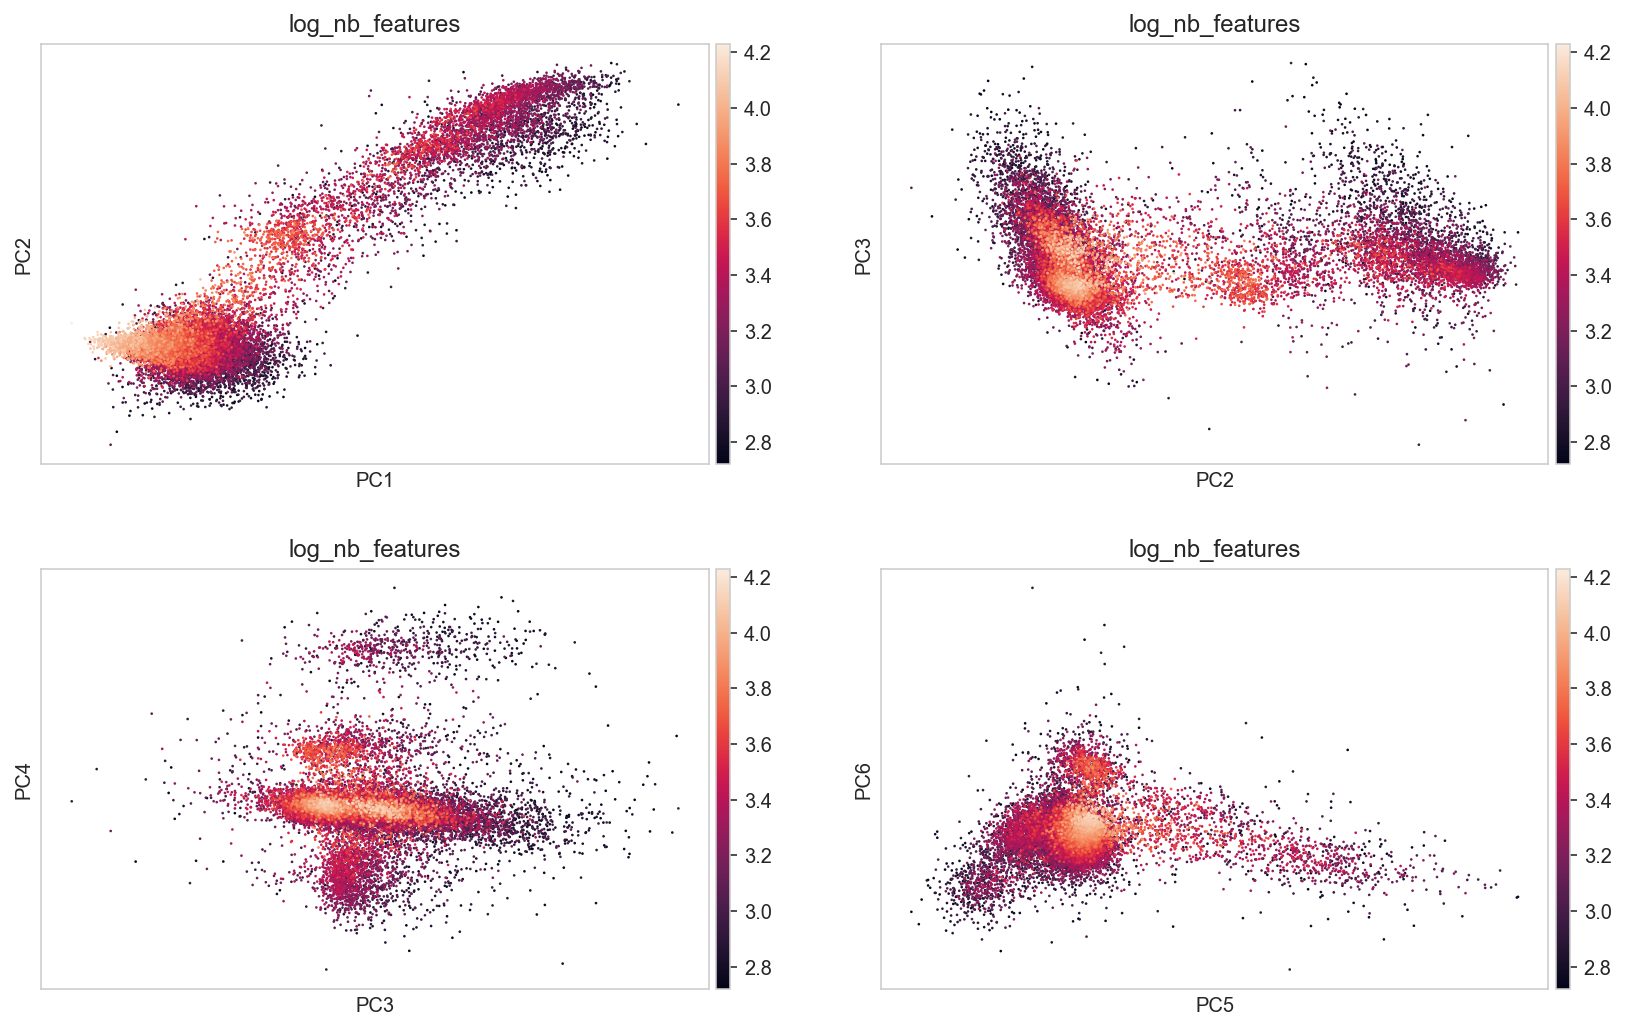

In [15]:
sc.pl.pca(adata_MK_norm, color='log_nb_features', components = ['1,2','2,3','3,4','5,6'], ncols=2)

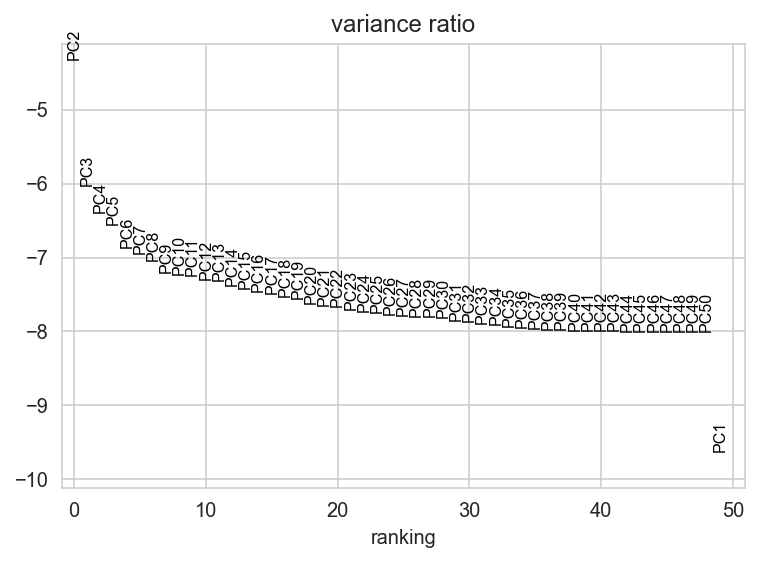

In [49]:
sc.pl.pca_variance_ratio(adata_MK_norm, log=True, n_pcs = 50)

In [ ]:
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

genes = adata_MK_norm.var['transcript_annotation']

for pc in [1,2,3]:
    g = adata_MK_norm.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata_MK_norm.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = adata_MK_norm[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), groupby=None, swap_axes = True, use_raw=False)

In [16]:
sc.pp.neighbors(adata_MK_norm, n_pcs = 30, n_neighbors = 15)

In [17]:
sc.tl.umap(adata_MK_norm, n_components=5)

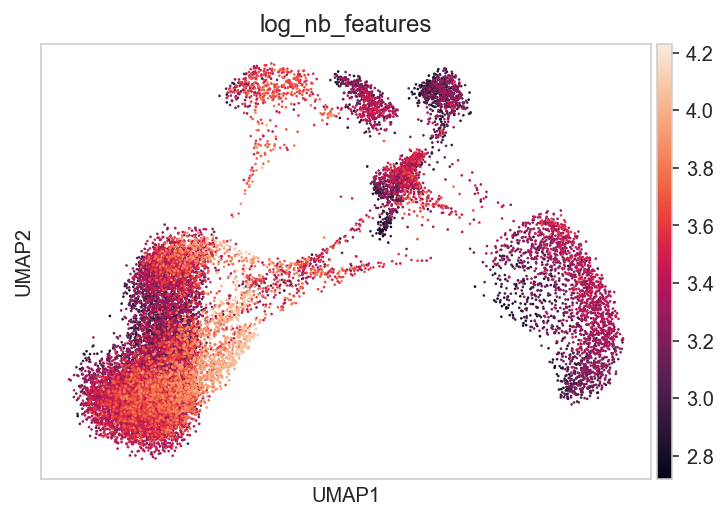

In [18]:
sc.pl.umap(adata_MK_norm, color=["log_nb_features"])

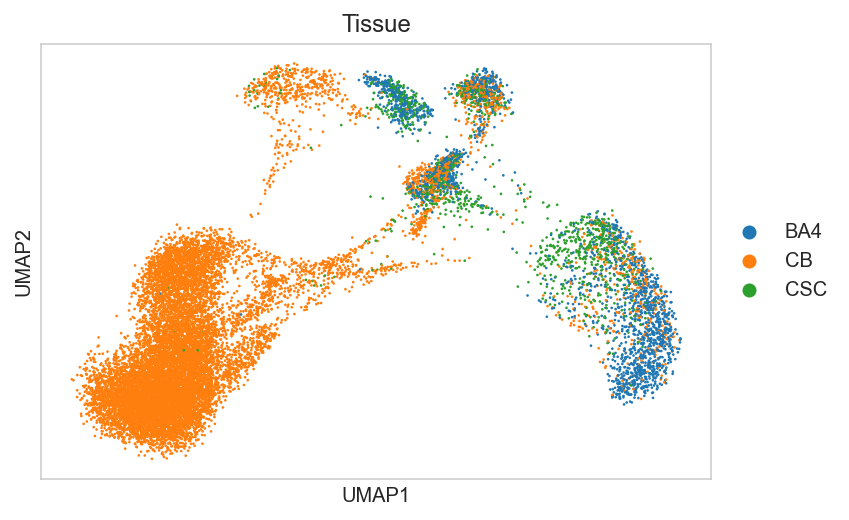

In [19]:
sc.pl.umap(adata_MK_norm, color=["Tissue"]) # 30 pcs for neighbors, 2 components for umap, 5 n_neighbors, euclidean

In [60]:
epi.tl.louvain(adata_MK_norm)
epi.tl.kmeans(adata_MK_norm, num_clusters=8)
epi.tl.hc(adata_MK_norm, num_clusters=10)

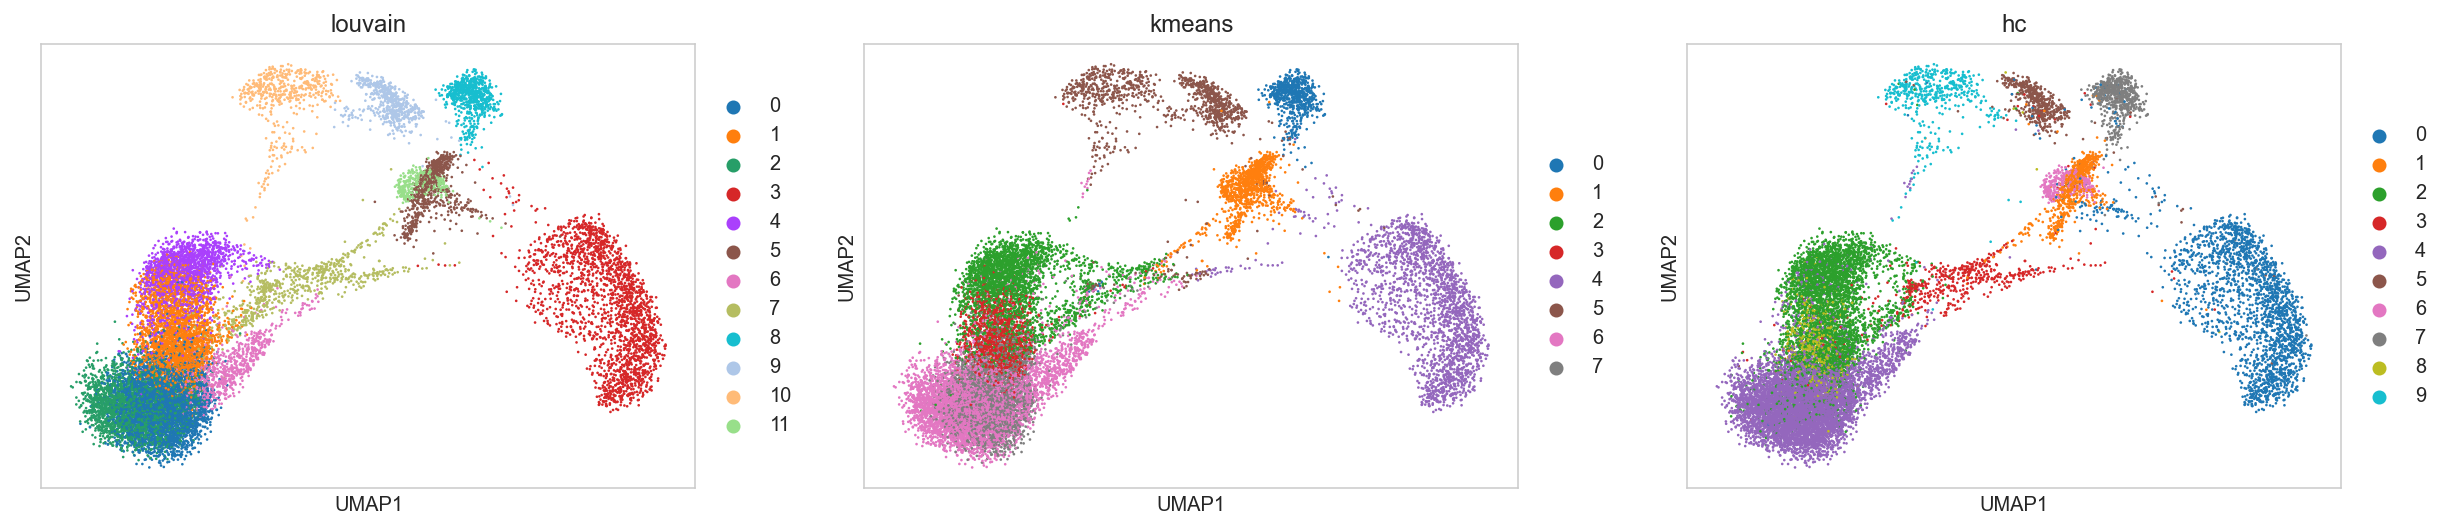

In [61]:
epi.pl.umap(adata_MK_norm, color=["louvain", "kmeans", "hc"])

In [ ]:
adata_MK_norm.write("data/epi/top60k_binned_2kb_count_matrix_RESULTS.h5ad")